In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.experiments import *
from LIMxCMBL.kernels import *

In [2]:
import matplotlib.pyplot as plt

In [3]:
k = np.logspace(-5, 3, 2**10)
pk_lin = ccl.linear_matter_power(cosmo, k, 1)
pk_nonlin = ccl.nonlin_matter_power(cosmo, k, 1)

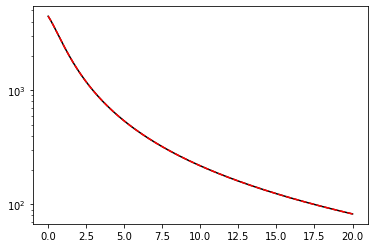

In [4]:
from scipy.interpolate import interp1d
dchidz = np.gradient(chis, zs)
f_dchidz = interp1d(x = zs, y = dchidz)

plt.plot(zs, dchidz, c='k')
plt.plot(zs, f_dchidz(zs), 'r--')
plt.yscale('log')

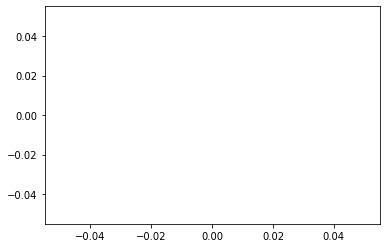

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colors

plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": "11",
    "font.family" : "11",
    'hatch.linewidth':0.1
})


In [6]:
2*np.pi * np.fft.rfftfreq(n=len(zs), d=np.mean(np.diff(chis)))

array([0.00000000e+00, 5.72772440e-04, 1.14554488e-03, ...,
       2.86271665e+00, 2.86328943e+00, 2.86386220e+00])

In [7]:
2*np.pi/(np.max(chis) - np.min(chis))

0.0005728297225182396

In [8]:
np.pi/(np.mean(np.diff(chis)))

2.863862197729939

In [9]:
KIs={
    'CCAT-prime': KI,
    'COMAP': KI_CO,
    'HETDEX': KI_Lya,
    'SPHEREx': KI_Lya,
    'CHIME': KI_HI
}

In [10]:
import matplotlib.ticker as mticker

In [11]:
import matplotlib.transforms as transforms

In [12]:
def hline_text(x, y, text, color="k", fontsize=12, linestyle="-", ax=None,
              left = None, right = None, path_effects = None, ha='right', lw=1,
              pad = .01):
    """ draw hline at y interrupted by text at x """
    if ax is None:
        ax = plt.gca()
    text += ' '
    text = ' ' + text
    label = ax.text(x, y, text, color='k', fontsize=fontsize,
                    va="center", ha=ha,
                   path_effects= path_effects)
    # draw text to get its bounding box
    ax.get_figure().canvas.draw()
    bbox = label.get_window_extent().transformed(ax.transAxes.inverted())
    bbox.x0 -= pad
    bbox.x1 += pad
    bbox = bbox.transformed(ax.transAxes).transformed(ax.transData.inverted())
    # add hlines next to bounding box
    if(left == None):
        left, right = ax.get_xlim()
    ax.hlines([y]*2, [left, bbox.x1], [bbox.x0, right], color=color, linestyle=linestyle, lw=lw)
    
    
    y0, y1 = bbox.y0, bbox.y1
    dy = (y1 - y0)
    yb = (y0 + y1)/2
    ax.plot([left, left], [y-dy/5, y+dy/5], color=color, lw=lw)
    ax.plot([right, right], [y-dy/5, y+dy/5], color=color, lw=lw)

In [13]:
kper_ys = [1e3, 24e2, 1e5, 8e6, 3e2]
kpar_ys = [2e2, 8e2, 3e5, 1e8, 9e2]

In [14]:
import matplotlib.patheffects as pe

In [15]:
e_order = ['CHIME',
          'HETDEX',
          'COMAP',
          'CCAT-prime',
          'SPHEREx']

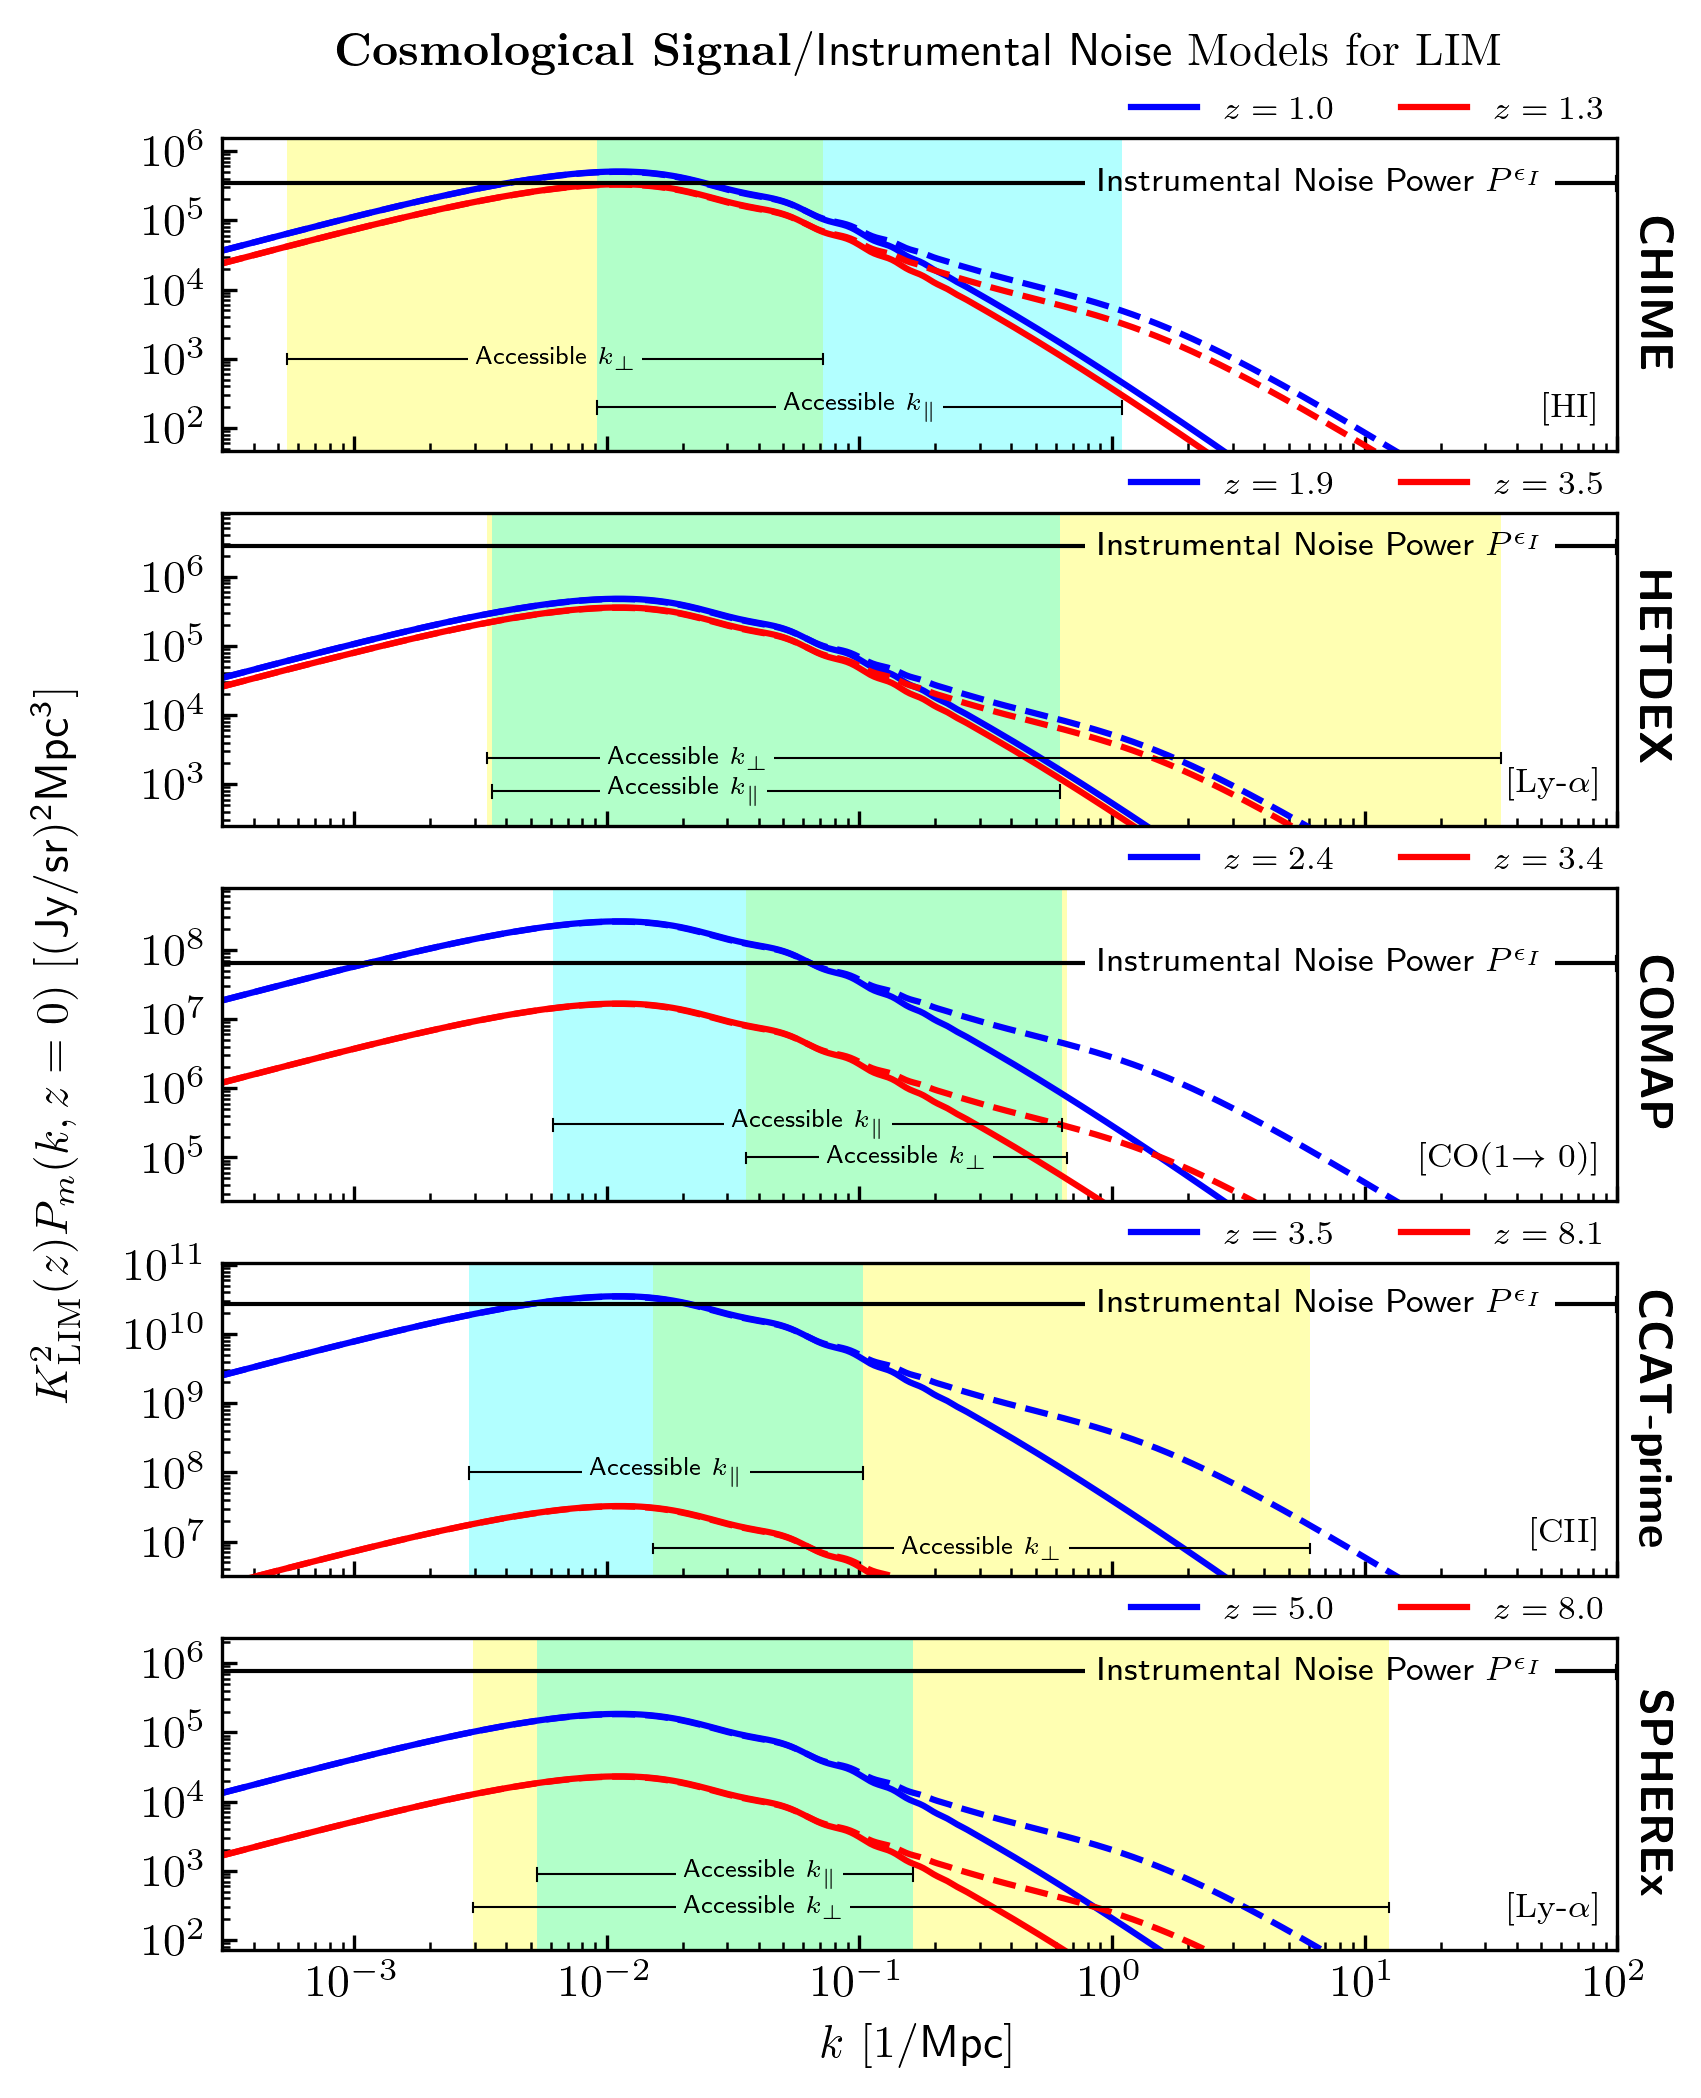

In [16]:
fig, axs = plt.subplots(nrows = len(experiments), ncols = 1, sharex = True, 
                       figsize=(6, 8),
                       facecolor='w', dpi=300)

for i,experiment in enumerate(e_order):
        
    ax = axs[i]
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)

    #load configuration of experiment
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    zcentral = (zmin + zmax)/2

    line_str = experiments[experiment]['line_str']

    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    chicentral = ccl.comoving_angular_distance(cosmo, 1/(1+zcentral))



    #kperp min max with central chi
    ell_fundamental = np.sqrt((2*np.pi)**2 / experiments[experiment]['Omega_field'].to(u.rad**2))
    ell_fundamental = np.array(ell_fundamental)

    ell_max_survey = np.sqrt((np.pi)**2 / experiments[experiment]['Omega_pix'].to(u.rad**2))
    ell_max_survey = np.array(ell_max_survey)

    kperp_min = ell_fundamental/chicentral #1/Mpc
    kperp_max = ell_max_survey/chicentral  #1/Mpc

    
    ax.fill_between([kperp_min, kperp_max], 
                     [0, 0], 
                     [1e100, 1e100], 
                     linewidth=0.0,
                     alpha = 0.3,
                     facecolor='yellow',)



    #kpar min max with resolving factor 
    if(experiment != 'CHIME'):
        R = experiments[experiment]['R']
    else:
        R = np.array(((nu_HI/(1+(zmin + zmax)/2))/(390 * u.kHz)).to(u.dimensionless_unscaled))
    dchi_central = (1+zcentral) / R * f_dchidz(zcentral)

    kpar_fundamental = 2*np.pi/(chimax - chimin)
    kpar_max_survey = np.pi / dchi_central

    

    ax.fill_between([kpar_fundamental, kpar_max_survey], 
                     [0, 0], 
                     [1e100, 1e100], 
                     linewidth=0,
                     alpha = 0.3,
                     facecolor='cyan', )
    


    #plot P3D LIM
    ax.tick_params(axis='both', which='both', direction='in')

    if(line_str == 'Lya'):
        line_str = r'Ly-$\alpha$'
    if(line_str == 'CO'):
        line_str = r'CO(1$\rightarrow$ 0)'

    idxs = [np.argmin(np.abs(zs - zmin)),
            np.argmin(np.abs(zs - zmax))]
    colors = ['b', 'r']

    for idx,c in zip(idxs, colors):
        z = zs[idx]
        ax.plot(k, (KIs[experiment][idx].to(u.Jy/u.sr))**2 * pk_lin, 
                 c = c,
                 label=r'$z=%.1f$'%(z))
        ax.plot(k, (KIs[experiment][idx].to(u.Jy/u.sr))**2 * pk_nonlin, 
                 c = c,
                 ls='--')
    ax.set_yscale('log')
    ax.set_xscale('log')


    #instrumentla noise
    _a, _b = Pei_dict[experiment]() #[(kJy/sr)^2 Mpc^3]

    _a = np.array(_a.to((u.Jy/u.sr)**2 * u.Mpc**3)) #[(Jy/sr)^2 Mpc^3]
    _b = np.array(_b.to((u.Jy/u.sr)**2 * u.Mpc**3)) #[(Jy/sr)^2 Mpc^3]
    Pei = max(_a, _b)



    #figure config
    leg = ax.legend(frameon=False, ncols = 2, 
                    bbox_to_anchor=(0., 1.00, 1., .5),
                    borderaxespad=0.,
                    loc = 'lower right',
                    bbox_transform=ax.transAxes,
                    fontsize = 8,)
    
    ax.text(1.01, 0.5, r'\textsf{\textbf{%s}}'%(experiment), 
            transform=ax.transAxes, 
            ha='left', va='center',
            rotation=-90)
    ax.text(1-0.01, 0.08, r'[%s]'%(line_str), 
            transform=ax.transAxes, 
            fontsize = 8,
            ha='right', va='bottom',)
    

    
    xleft = 3e-4
    xright = 1e2
    plotted_idxs = np.where((k <= xright) & (k>=xleft))


    yhigh = 3*max(np.array(np.max((KIs[experiment][idxs[0]].to(u.Jy/u.sr))**2  * pk_lin[plotted_idxs])), Pei)
    ax.set_xlim(xleft, xright)
    ax.set_ylim(yhigh/2**15, yhigh)
    ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999,))
    ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs='all'))    
    
    
    _x = np.sqrt(kperp_min * kperp_max)
    _x2 = np.sqrt(kpar_fundamental * kpar_max_survey)

    _ha = 'center'
    if(experiment == 'HETDEX' or experiment == 'SPHEREx'):
        _ha = 'left'
        
    if(experiment == 'HETDEX'):
        _x = _x2 = 1e-2
        
        
    if(experiment == 'SPHEREx'):
        _x = _x2 = 2e-2

    hline_text(x = _x, 
               y=kper_ys[i],  text=r'{\sf Accessible} $k_\perp$',
              color='k', fontsize=6, linestyle='-', ax=ax, 
              left = kperp_min, right=kperp_max,
              ha = _ha, lw=0.5, pad=0.005)

    
    hline_text(x = _x2, 
               y=kpar_ys[i],  text=r'{\sf Accessible} $k_\parallel$',
              color='k', fontsize=6, linestyle='-', ax=ax, 
              left = kpar_fundamental, right=kpar_max_survey,
              ha = _ha, lw=0.5, pad=0.005)
    hline_text(x = 5e1, y=Pei,  text=r'{\sf Instrumental Noise Power} $P^{\epsilon_I}$',
              color='k', fontsize=8, linestyle='-', ax=ax)

    
    
axs[-1].set_xlabel(r'$k\ [1 / {\sf Mpc}]$', )
axs[2].set_ylabel(r'$K_{\rm LIM}^2(z)P_m(k, z=0)\ [{\sf (Jy/sr)^2 Mpc^3}]$'+'\n')


# plt.subplots_adjust(wspace=0, hspace=0)
axs[0].set_title(r'\textbf{Cosmological Signal}/{\sf Instrumental Noise} Models for LIM'+'\n',
                fontsize=11,)

plt.savefig('figures/012.002.line-models.pdf', bbox_inches='tight')